# Federated Learning (FL) - Titanic

## Objective
Train a ML model to predict the survival probability in a federated setup and benchmark it against a model being trained on the full dataset.

## Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from pathlib import Path

In [2]:
# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# pandas show full output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 200)

# add module path
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src import config
from src import preprocess
from src import visual

## Load data
For the exploratory data analysis in a federated set-up, we assume that we can only see one of the provided the datasets while the other remains in control of the other data party. 

Hence, we only look at dataset A.

In [5]:
df_a = config.load_raw_data_a()
df_a.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
1,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C
2,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
3,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
4,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


## Statistics

In [6]:
print(f'Number of records {df_a.shape[0]} \nNumber of columns: {df_a.shape[1]}')

Number of records 306 
Number of columns: 12


In [7]:
df_a.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,306,306,306,111,306
unique,306,2,254,94,3
top,"McCarthy, Mr. Timothy J",male,S.O.C. 14879,E101,S
freq,1,230,5,3,243


Looking at the range between the 75% quantile and max, we expect that Fare likely has some outliers

In [8]:
df_a.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,306.000000,306.000000,306.000000,274.000000,306.000000,306.000000,306.000000
mean,449.852941,0.431373,1.601307,34.081204,0.366013,0.339869,39.226893
std,248.973515,0.496079,0.490431,15.422127,0.581142,0.679087,54.911557
min,7.000000,0.000000,1.000000,0.670000,0.000000,0.000000,0.000000
25%,238.250000,0.000000,1.000000,24.000000,0.000000,0.000000,13.000000
50%,453.500000,0.000000,2.000000,32.750000,0.000000,0.000000,26.000000
75%,665.250000,1.000000,2.000000,45.000000,1.000000,0.000000,38.875000
max,890.000000,1.000000,2.000000,80.000000,3.000000,4.000000,512.329200


Missing values per column.
Cabin has too many missing values and thus it's better to remove it. However, Age could be imputed using the median or a more sophisticated multi-variate approach. We favour the latter since the columns like Fare, number of siblings/spouses, and number of parents/children seem quite informative to infer Age.

In [9]:
df_a.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             32
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          195
Embarked         0
dtype: int64

## Visualizations

Drop features that do not contain statistical information we would like to preserve.

In [10]:
print(f"Drop features that do not contain statistical information to preserve: {config.FEATURES_DROP}")
df = df_a.drop(config.FEATURES_DROP, axis=1, errors='ignore')

Drop features that do not contain statistical information to preserve: ['PassengerId', 'pred', 'Name', 'Ticket', 'Cabin']


### Univariate

When looking at the boxplot the only column that stands out is Fare, which might have some unrealistic values (i.e. outliers).

<AxesSubplot:>

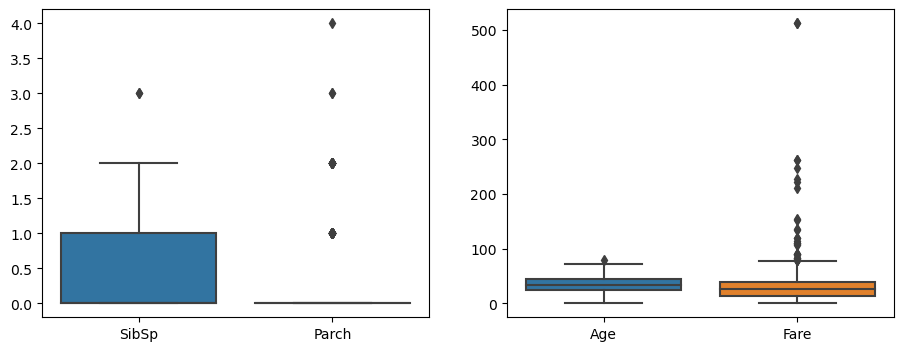

In [11]:
low_range_columns = ['SibSp', 'Parch']
high_range_columns = ['Age', 'Fare']
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.boxplot(df[low_range_columns], ax=ax[0])
sns.boxplot(df[high_range_columns], ax=ax[1])

<Figure size 640x480 with 0 Axes>

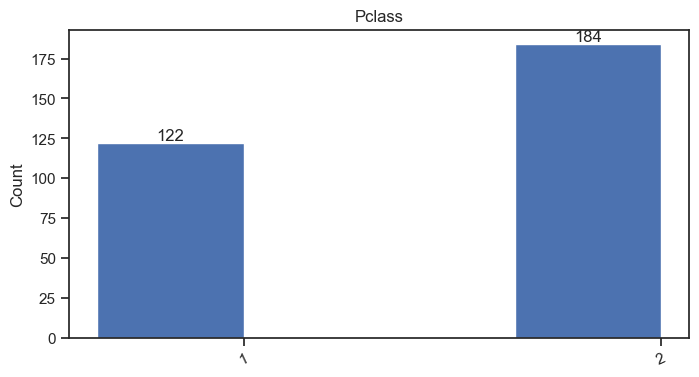

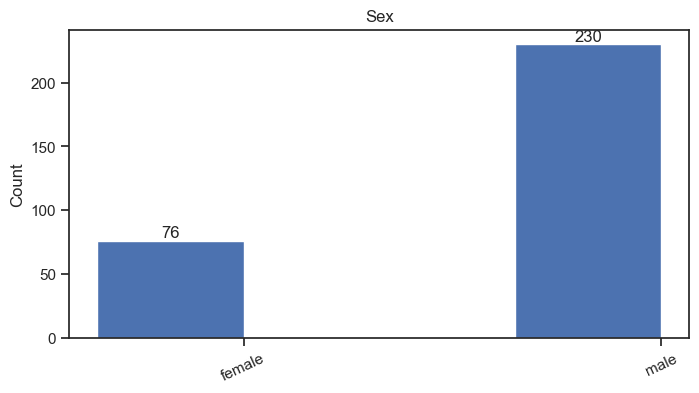

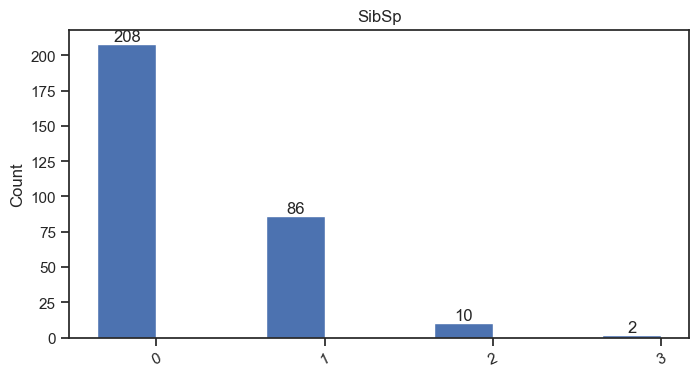

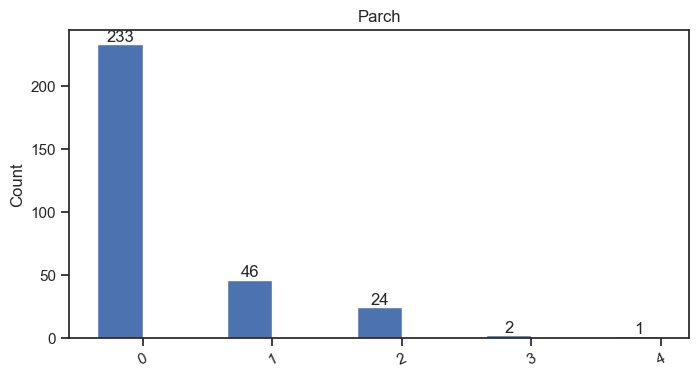

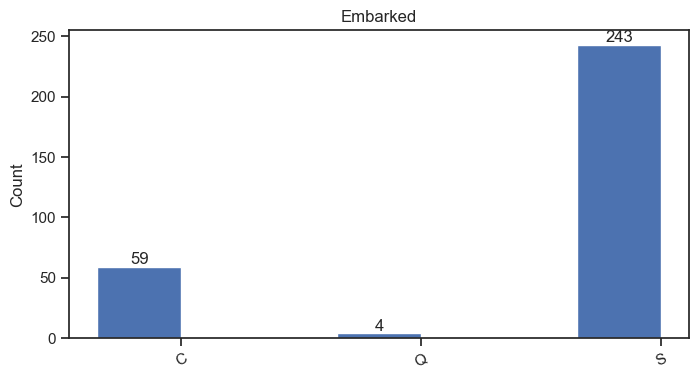

In [12]:
subset = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
visual.plot_distributions(df_a, subset_columns=subset, sort_index=True, dropna=True, normalize=False)

### Multivariate

When looking at the pairplot below, we get a sense for some of patterns between features that we would like to examine a little closer, for example the relation between Age and Survived. We zoom on these in the sections below.

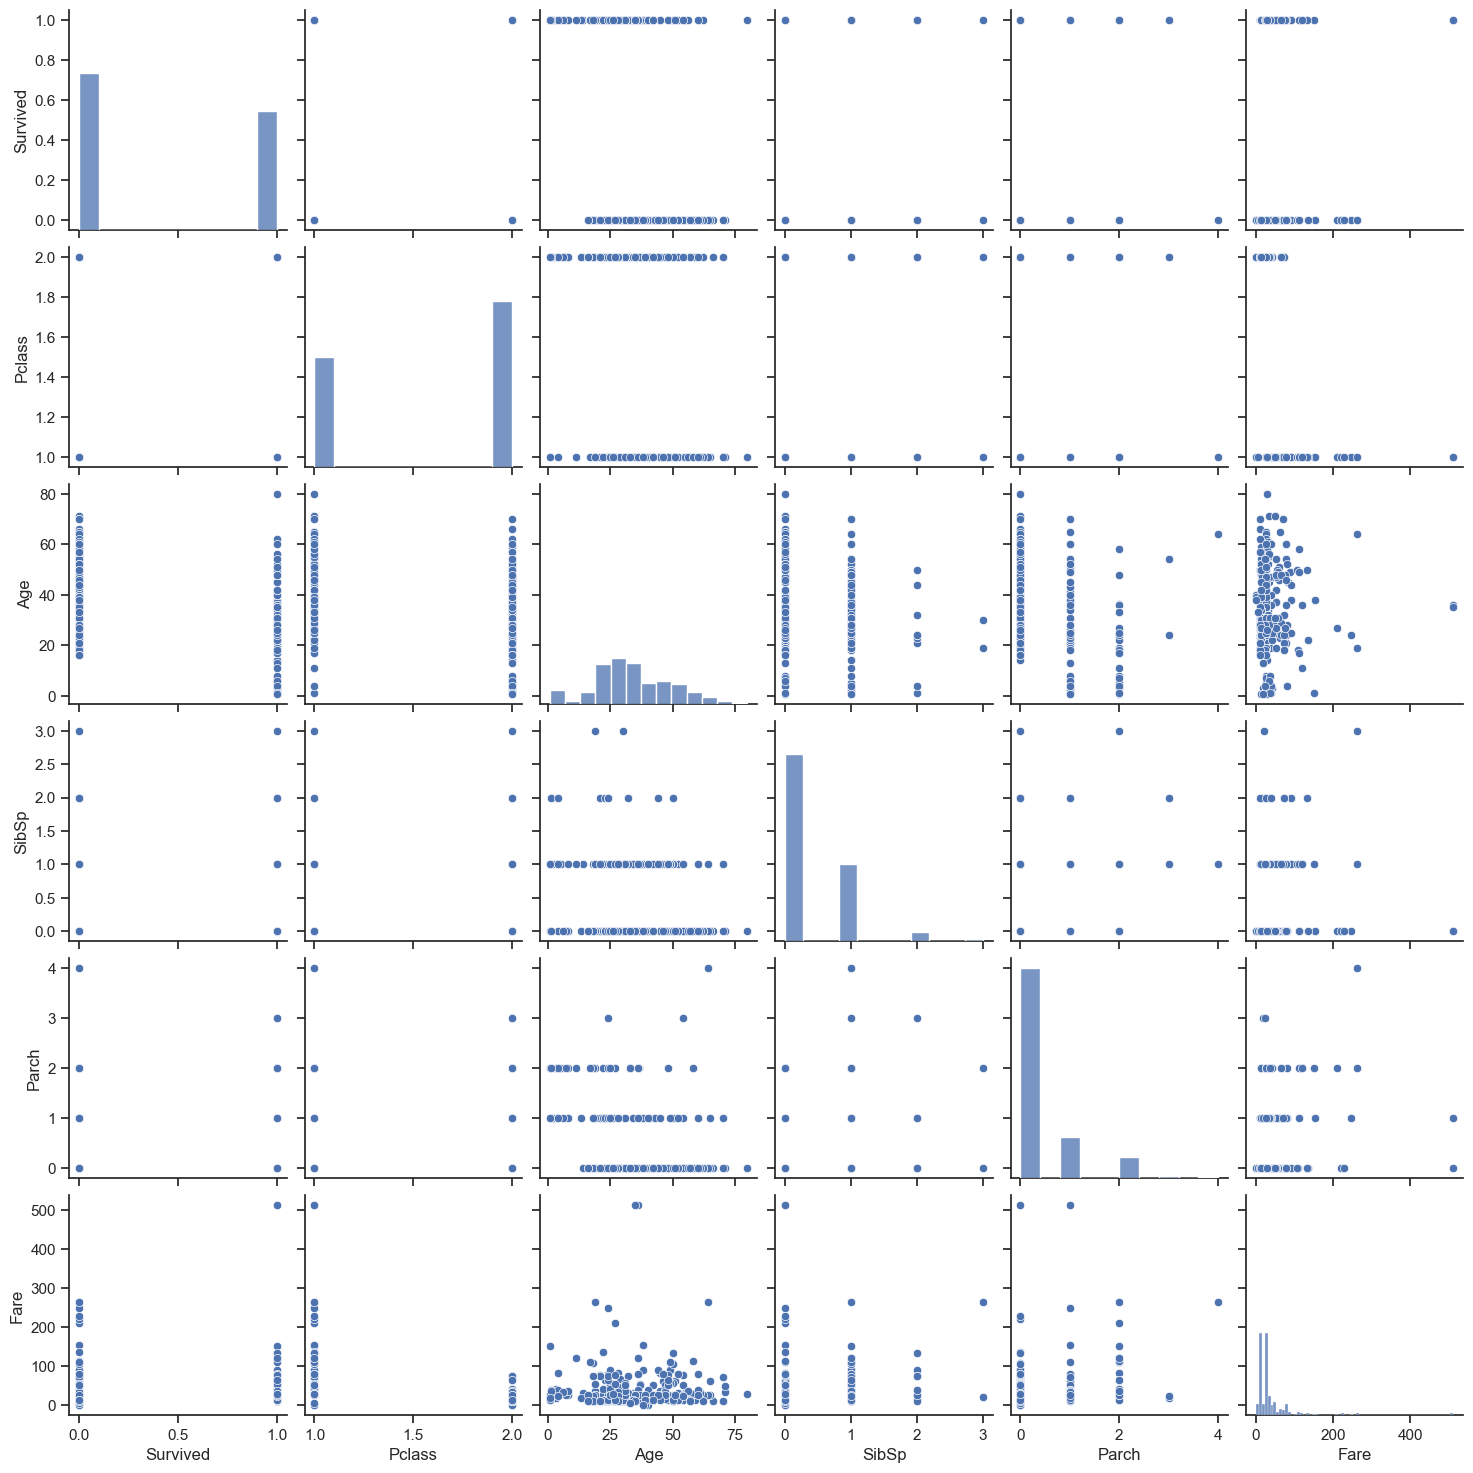

In [14]:
sns.pairplot(df)

Below we see the relation between features and the target variable Survived. Observe the following
- Young children (<10) are more likely to survive, while seniors (>65) are less likely to survive.
- There doesn't seem to be a clear seperation between Fare and Survived, except for the outliers.

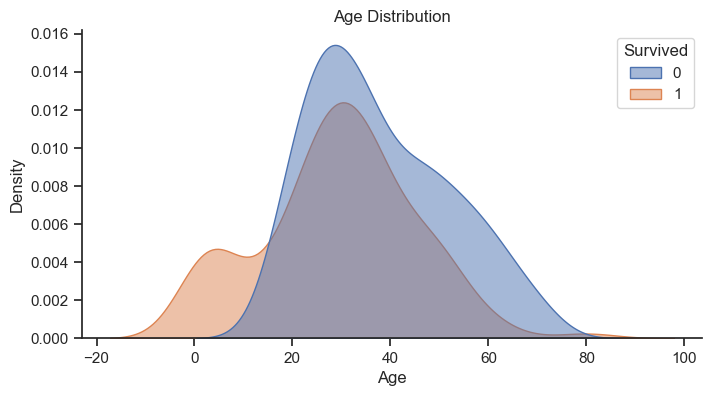

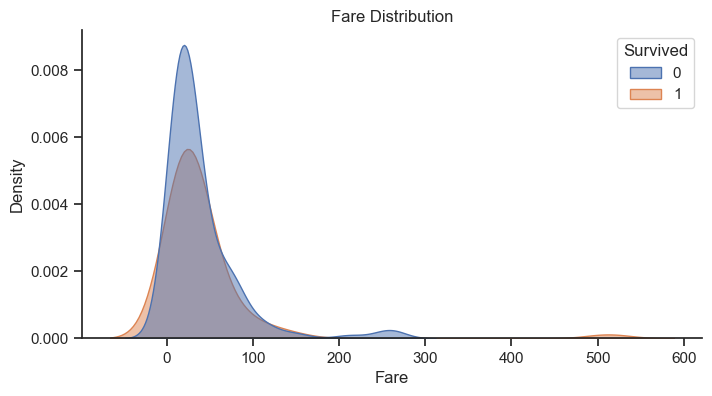

In [59]:
visual.plot_kde(df, x='Age', hue='Survived')
visual.plot_kde(df, x='Fare', hue='Survived')

When looking at Sex and Survived, we see a more obvious difference. Women seem to have higher chances for survival compared to men. This is likely to become a very informative feature when training a classifier.

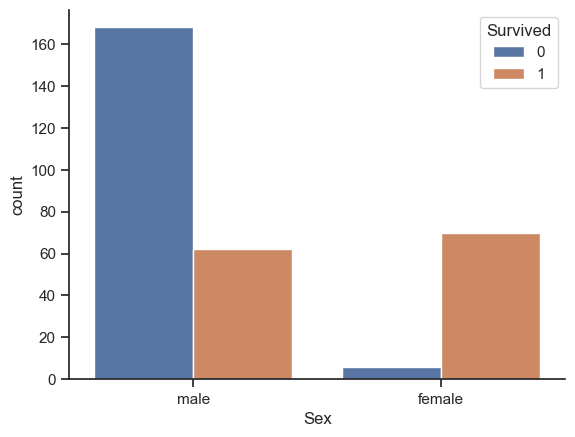

In [15]:
sns.countplot(df_a, x='Sex', hue='Survived')
sns.despine()

When looking at the correlations, none of them are very strong >0.5, however we observe the following.

Strongest positive correlations:
- Parch and SibSp: not unexpected, both measure family relations
- Parch and Fare: the more parents/children you have the more likely you are to pay a higher fare
- Parch and Survived: the more parents/children you have the more likely you surive.

Strongest negative correlations:
- Pclass and Fare: not unexpected, higher fares will put you in upper class (where 1 is upper)
- Age and Pclass: not unexpected, the older you are the more like you belong to upper class    
    

<AxesSubplot:>

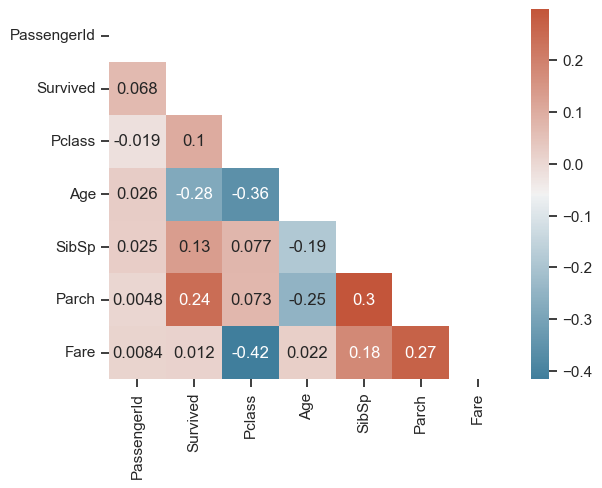

In [16]:
visual.plot_correlation(df_a.corr(), annot=True)

Target class seems very well balanced

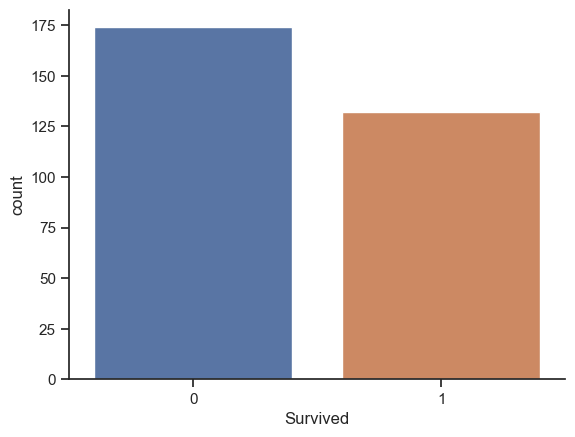

In [17]:
sns.countplot(df_a, x='Survived')
sns.despine()

## Conclusion
In this notebook we examined some of the statiscal patterns in dataset A. However, we cannot assume that these patterns will hold up for the complete dataset (with the data provided by party B). Hence, we need to be careful about our observations and potentially test for them in a federated setup to ensure we have similar statistical distributions in both datasets.

In the next notebook, we show how to train a ML classifier in a federated manner and compare the results to a ML model trained on a centralized dataset.